In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.impute import SimpleImputer

from eval_utils import *

В работе используется датасет, предназначенный для прогнозирования того, сколько клиент заплатит за страховку (размер страховой премии, Premium Amount). Набор данных (https://www.kaggle.com/competitions/playground-series-s4e12) был сгенерирован при помощи нейронной сети , обученной на исходном датасете Insurance Premium Prediction, поэтому распределения признаков близки к реальным, но не полностью совпадают с оригиналом.

## EDA

Загрузим данные и посмотрим на стат. характеристики

In [4]:
df = pd.read_csv('train.csv', index_col='id')
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [5]:
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")


Размер датасета: 1200000 строк, 20 столбцов


In [6]:
df.columns = df.columns.str.strip().str.replace(" ", "_")

In [7]:
print("\nИнформация о типах данных:")
print(df.info())


Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual_Income         1155051 non-null  float64
 3   Marital_Status        1181471 non-null  object 
 4   Number_of_Dependents  1090328 non-null  float64
 5   Education_Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health_Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy_Type           1200000 non-null  object 
 10  Previous_Claims       835971 non-null   float64
 11  Vehicle_Age           1199994 non-null  float64
 12  Credit_Score          1062118 non-null  float64
 13  Insurance_Duration    1199999 non-null  float64
 14  Policy_Star

In [8]:
print("\nСтатистическое описание числовых признаков:")
print(df.describe())


Статистическое описание числовых признаков:
                Age  Annual_Income  Number_of_Dependents  Health_Score  \
count  1.181295e+06   1.155051e+06          1.090328e+06  1.125924e+06   
mean   4.114556e+01   3.274522e+04          2.009934e+00  2.561391e+01   
std    1.353995e+01   3.217951e+04          1.417338e+00  1.220346e+01   
min    1.800000e+01   1.000000e+00          0.000000e+00  2.012237e+00   
25%    3.000000e+01   8.001000e+03          1.000000e+00  1.591896e+01   
50%    4.100000e+01   2.391100e+04          2.000000e+00  2.457865e+01   
75%    5.300000e+01   4.463400e+04          3.000000e+00  3.452721e+01   
max    6.400000e+01   1.499970e+05          4.000000e+00  5.897591e+01   

       Previous_Claims   Vehicle_Age  Credit_Score  Insurance_Duration  \
count    835971.000000  1.199994e+06  1.062118e+06        1.199999e+06   
mean          1.002689  9.569889e+00  5.929244e+02        5.018219e+00   
std           0.982840  5.776189e+00  1.499819e+02        2.594331

In [9]:
print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())


Проверка на пропущенные значения:
Age                      18705
Gender                       0
Annual_Income            44949
Marital_Status           18529
Number_of_Dependents    109672
Education_Level              0
Occupation              358075
Health_Score             74076
Location                     0
Policy_Type                  0
Previous_Claims         364029
Vehicle_Age                  6
Credit_Score            137882
Insurance_Duration           1
Policy_Start_Date            0
Customer_Feedback        77824
Smoking_Status               0
Exercise_Frequency           0
Property_Type                0
Premium_Amount               0
dtype: int64


Визуализируем их, рассчитав процент от общего числа строк:

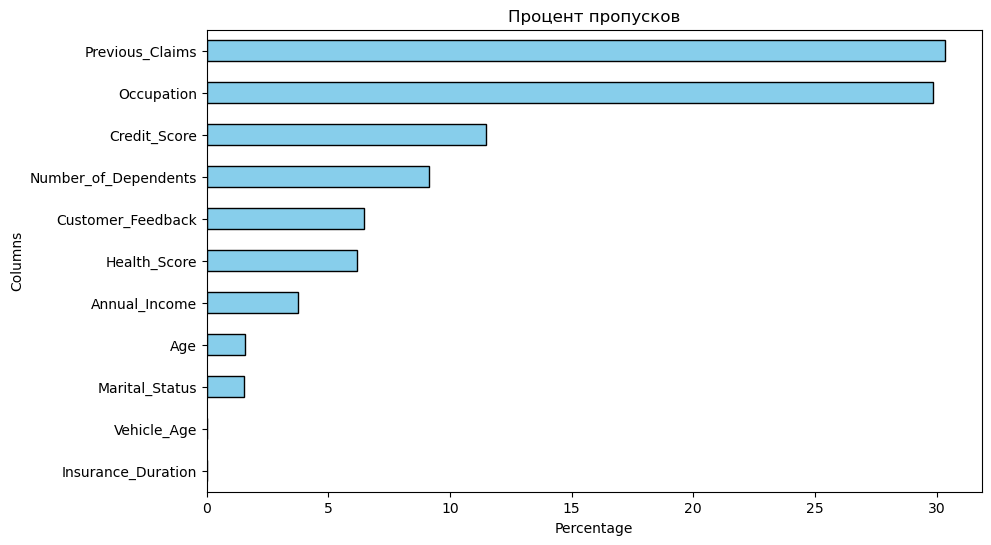

In [ ]:
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=True)

missing_percentage.plot(
    kind='barh',
    figsize=(10, 6),
    color='skyblue',
    edgecolor="black",
    linewidth=1.0
)
plt.title('Процент пропусков')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.show()


Также построим карту 

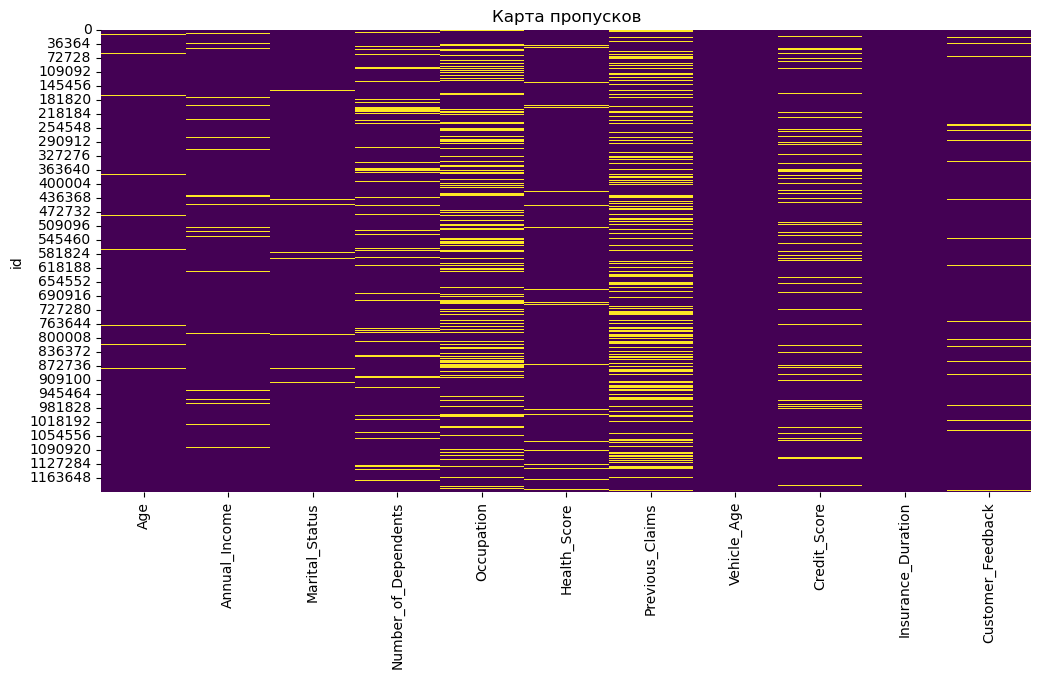

In [11]:
cols_with_missing = df.columns[df.isnull().any()]

plt.figure(figsize=(12, 6))
sns.heatmap(df[cols_with_missing].isnull(), cbar=False, cmap='viridis')
plt.title('Карта пропусков')
plt.show()

In [12]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


Признаки с историей заявлений и рода деятельности клиента имеют наибольший процент по пропускам (ближе к 30%). Также больше 5 процентов пропусков имеют столбцы содержащие отзыв клиента, его кредитный рейтинг, показатель здоровья и кол-во детей на иждивении. Остальные признаки (Возраст, семейное положение, годовой доход) имеют меньше 5 процентов пропусков.

В ряде признаков пропуски равномерно распределены по всем строкам, в некоторых — локализованы в определённых строках.

In [13]:
df["Policy_Start_Date"] = pd.to_datetime( df["Policy_Start_Date"] )
df['Policy_Year'] = df["Policy_Start_Date"].dt.year
df['Policy_Month'] = df["Policy_Start_Date"].dt.month
df['Policy_Day'] = df["Policy_Start_Date"].dt.day


In [14]:
target_col = 'Premium_Amount'

Прежде чем приступить к визуализации данных, рассчитаем уникальное кол-во значений в каждом столбце

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 23 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Age                   1181295 non-null  float64       
 1   Gender                1200000 non-null  object        
 2   Annual_Income         1155051 non-null  float64       
 3   Marital_Status        1181471 non-null  object        
 4   Number_of_Dependents  1090328 non-null  float64       
 5   Education_Level       1200000 non-null  object        
 6   Occupation            841925 non-null   object        
 7   Health_Score          1125924 non-null  float64       
 8   Location              1200000 non-null  object        
 9   Policy_Type           1200000 non-null  object        
 10  Previous_Claims       835971 non-null   float64       
 11  Vehicle_Age           1199994 non-null  float64       
 12  Credit_Score          1062118 non-null  float64

In [16]:
numerical_cols = ["Age", "Annual_Income", "Health_Score", "Credit_Score", "Vehicle_Age"]

categorical_cols = ["Gender", "Marital_Status", "Education_Level", "Occupation", "Location", "Policy_Type", 
                "Smoking_Status", "Exercise_Frequency", "Property_Type", "Customer_Feedback", "Number_of_Dependents", "Previous_Claims", "Insurance_Duration"]

In [17]:
categorical_cols

['Gender',
 'Marital_Status',
 'Education_Level',
 'Occupation',
 'Location',
 'Policy_Type',
 'Smoking_Status',
 'Exercise_Frequency',
 'Property_Type',
 'Customer_Feedback',
 'Number_of_Dependents',
 'Previous_Claims',
 'Insurance_Duration']

In [18]:
summary = []

for col in df.columns:
    if col in numerical_cols:
        col_type = "Числовой"
    elif col in categorical_cols:
        col_type = "Категориальный"
    else:
        col_type = "Другой тип"
    
    summary.append({
        "Столбец": col,
        "Тип": col_type,
        "Уникальные значения": df[col].nunique(),
    })

summary_df = pd.DataFrame(summary)
summary_df

,Столбец,Тип,Уникальные значения
0,Age,Числовой,47
1,Gender,Категориальный,2
2,Annual_Income,Числовой,88593
3,Marital_Status,Категориальный,3
4,Number_of_Dependents,Категориальный,5
5,Education_Level,Категориальный,4
6,Occupation,Категориальный,3
7,Health_Score,Числовой,532657
8,Location,Категориальный,3
9,Policy_Type,Категориальный,3


Первым делом хочется посмотреть на распределение таргета, т.к. изначально в соревновании была метрика RMSLE, построим его еще и преобразовав в логарифм

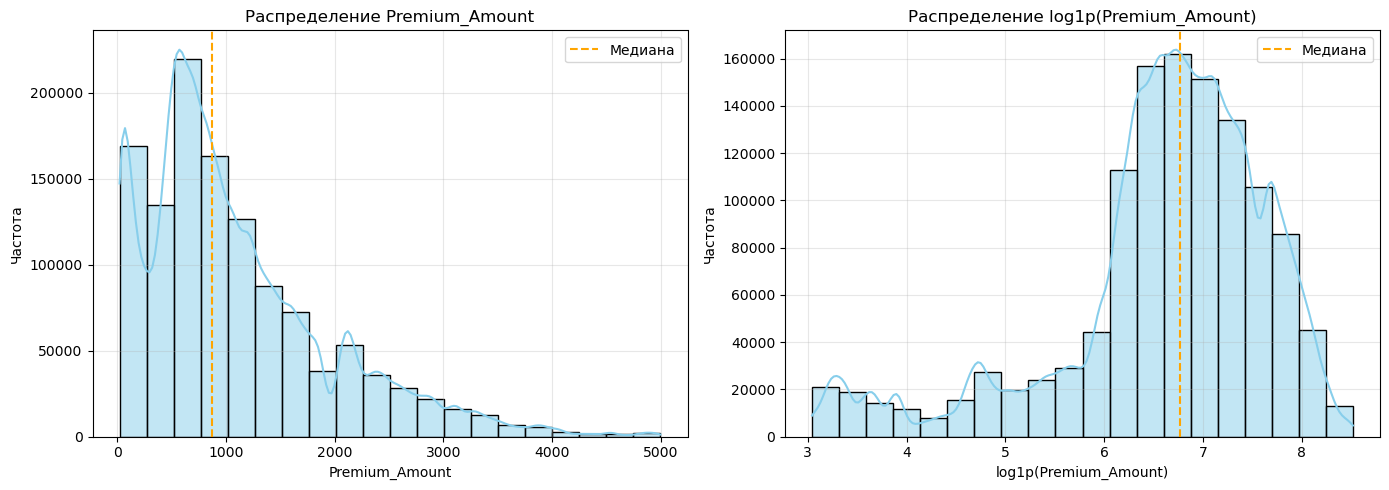

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Premium_Amount'], bins=20, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Распределение Premium_Amount')
ax[0].set_xlabel('Premium_Amount')
ax[0].set_ylabel('Частота')
ax[0].grid(True, alpha=0.3)
ax[0].axvline(df['Premium_Amount'].median(), color="orange", linestyle="--", label="Медиана")
ax[0].legend()

premium_log = np.log1p(df['Premium_Amount'])

sns.histplot(premium_log, bins=20, kde=True, color='skyblue', ax=ax[1])
ax[1].set_title('Распределение log1p(Premium_Amount)')
ax[1].set_xlabel('log1p(Premium_Amount)')
ax[1].set_ylabel('Частота')
ax[1].grid(True, alpha=0.3)
ax[1].axvline(premium_log.median(), color="orange", linestyle="--", label="Медиана")
ax[1].legend()

plt.tight_layout()
plt.show()


Изначальное распределение очень ассиметричное с правосторонним хвостом. Много значений в районе от 200 до 1000, есть существенные выбросы до 5000. После логарифмирования распределения стало почти нормальным и более симметричным.

Продолжим анализ с числовых признаков, для этого первым делом построим корреляционную матрицу, чтобы оценить взаимосвязь с таргетом

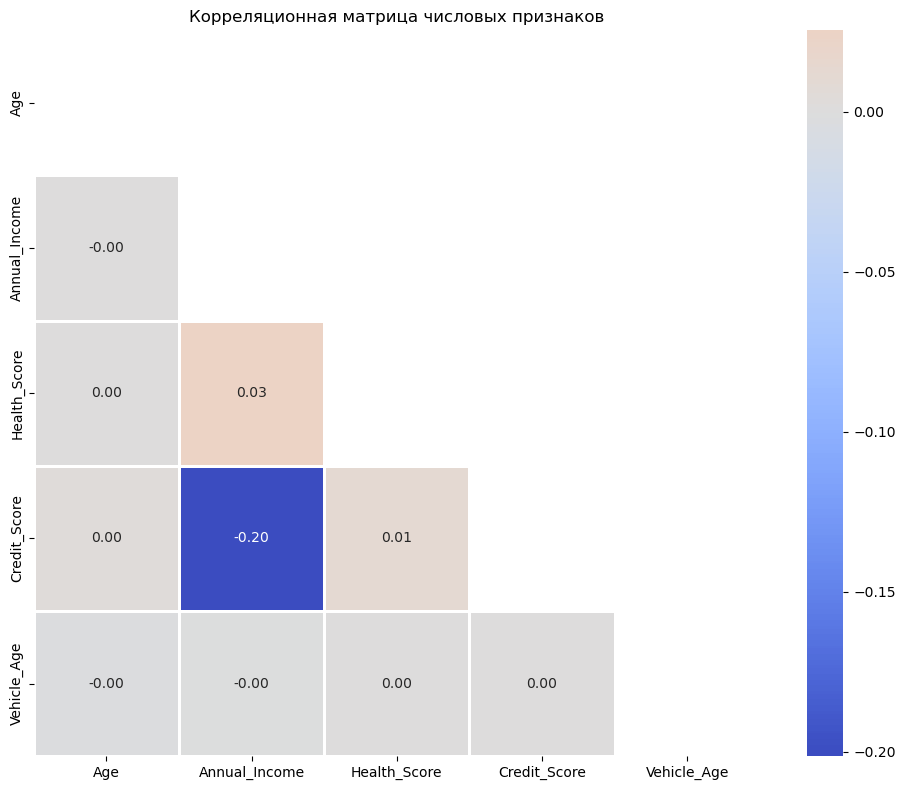

In [19]:
if len(numerical_cols) > 0:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr(numeric_only=True)
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Корреляционная матрица числовых признаков')
    plt.tight_layout()
    plt.show()

Все коэффициенты корреляции очень низкие, близкие к нулю:

Ни одна пара признаков не демонстрирует сильной линейной корреляции (положительной или отрицательной). Наибольшее абсолютное значение равно -0,20, между Credit_Score и Annual_Income .

Далее построим распределения этих признаков:

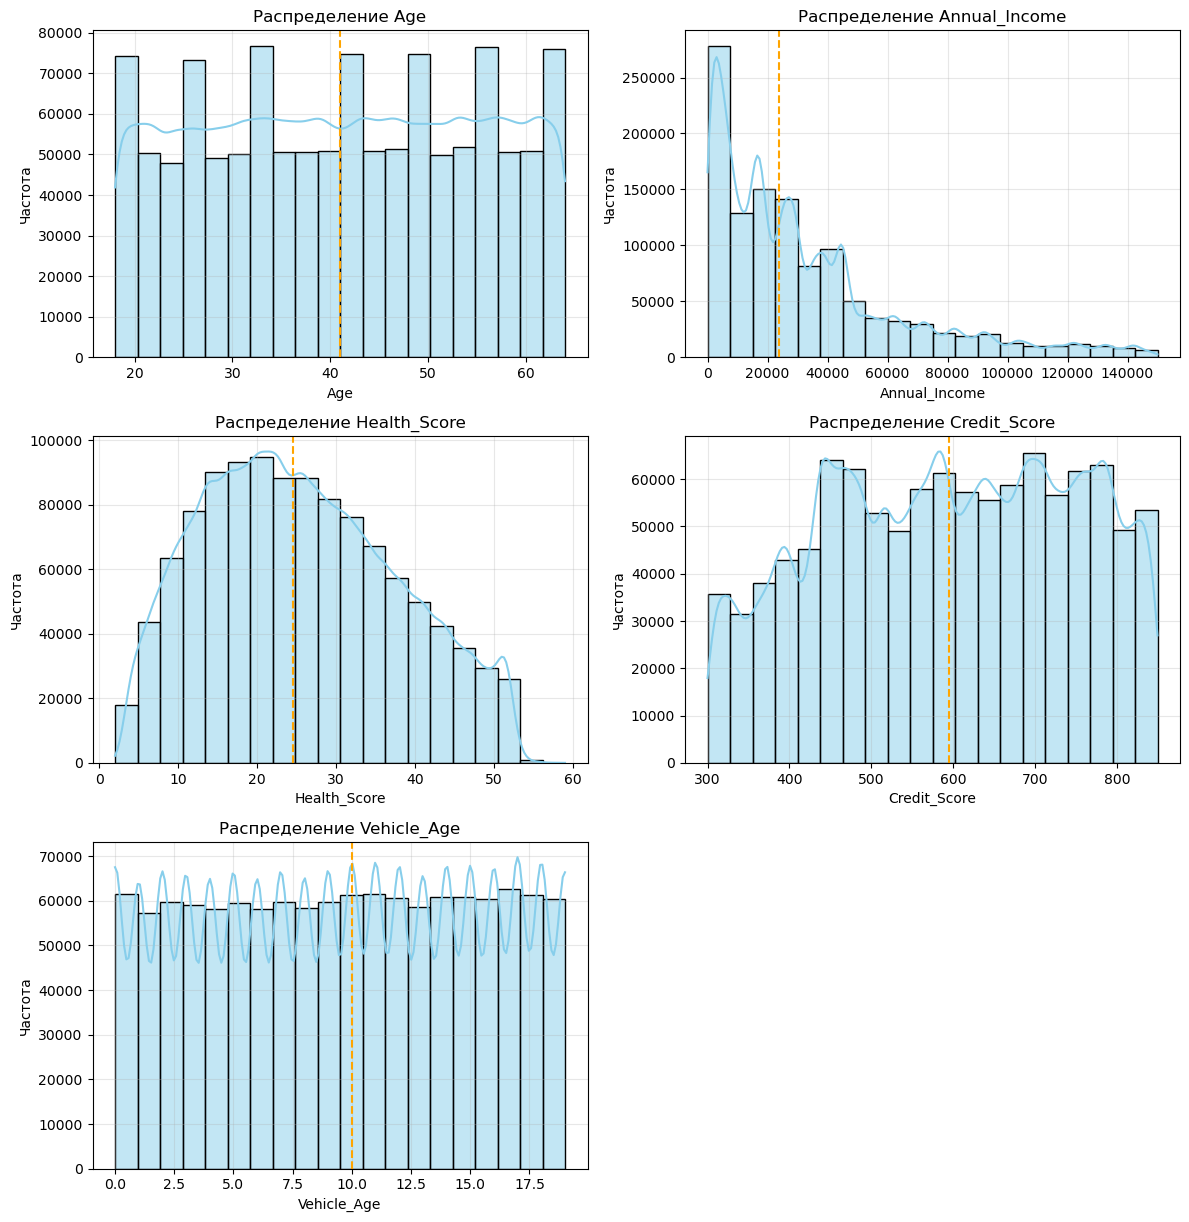

In [20]:
n = len(numerical_cols)

fig, ax = plt.subplots(n, 2, figsize=(12, n * 4))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=20, kde=True, color='skyblue', ax=ax[i])
    ax[i].set_title(f'Распределение {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Частота')
    ax[i].grid(True, alpha=0.3)
    ax[i].axvline(df[col].median(), color="orange", linestyle="--", label="Медиана")

for j in range(len(numerical_cols), len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

In [21]:
df['Age'].skew(skipna=True)

np.float64(-0.012531917883062616)

Возраст клиентов распределён равномерно, а признак здоровья имеет форму, близкую к нормальной.

Годовой доход имеет правостороннее распределение, большинство клиентов имеют низкий или средний доход. 

Кредитный счет и возраст автомобиля также распределены симметрично и равномерно, соответственно

Также для численных признаков построим боксплоты:

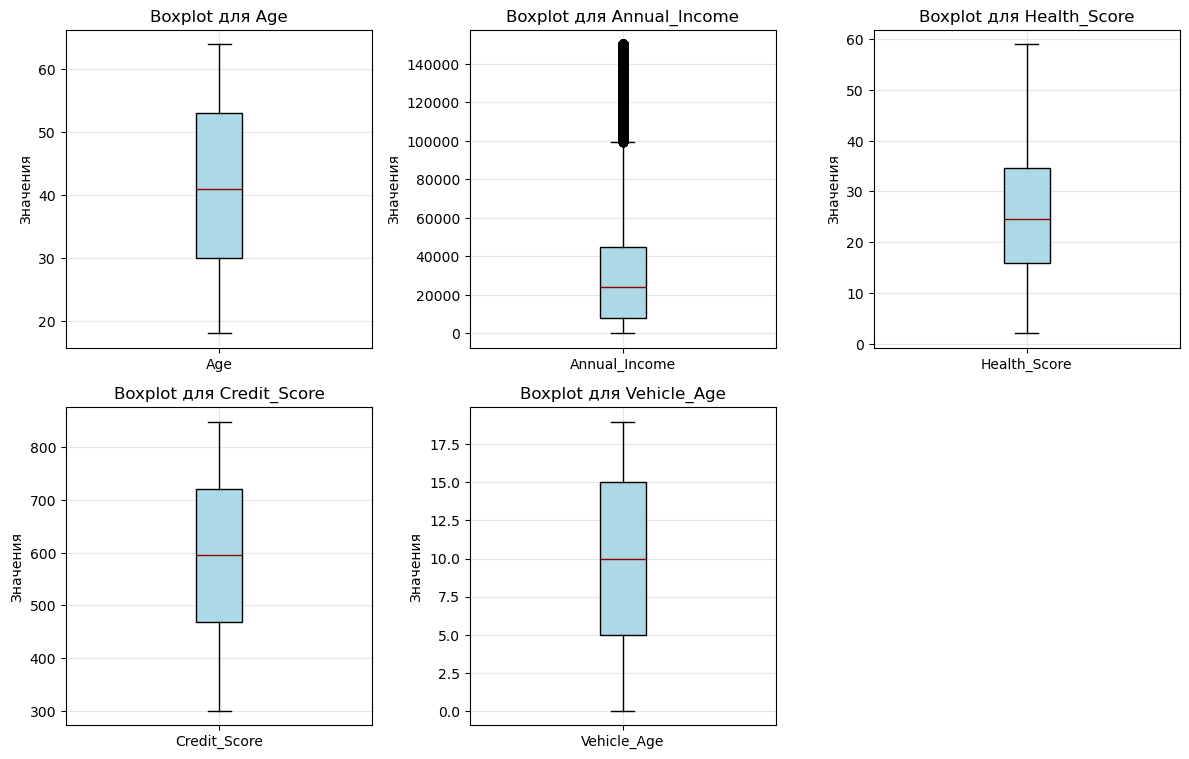

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(12, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    box_data = [df[col].dropna().values]
    bp = axes[i].boxplot(box_data, labels=[col], patch_artist=True)

    bp['boxes'][0].set_facecolor('lightblue')
    bp['medians'][0].set_color('darkred')

    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_ylabel('Значения')
    axes[i].grid(True, alpha=0.3)

for j in range(len(numerical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Признак с годовым доходом имеет значительные выбросы, однако это связано с самим распределением признака и удалять их нельзя

Теперь построим распределения для категориальных признаков:

In [23]:
categorical_cols

['Gender',
 'Marital_Status',
 'Education_Level',
 'Occupation',
 'Location',
 'Policy_Type',
 'Smoking_Status',
 'Exercise_Frequency',
 'Property_Type',
 'Customer_Feedback',
 'Number_of_Dependents',
 'Previous_Claims',
 'Insurance_Duration']

In [24]:
df.columns

Index(['Age', 'Gender', 'Annual_Income', 'Marital_Status',
       'Number_of_Dependents', 'Education_Level', 'Occupation', 'Health_Score',
       'Location', 'Policy_Type', 'Previous_Claims', 'Vehicle_Age',
       'Credit_Score', 'Insurance_Duration', 'Policy_Start_Date',
       'Customer_Feedback', 'Smoking_Status', 'Exercise_Frequency',
       'Property_Type', 'Premium_Amount', 'Policy_Year', 'Policy_Month',
       'Policy_Day'],
      dtype='object')

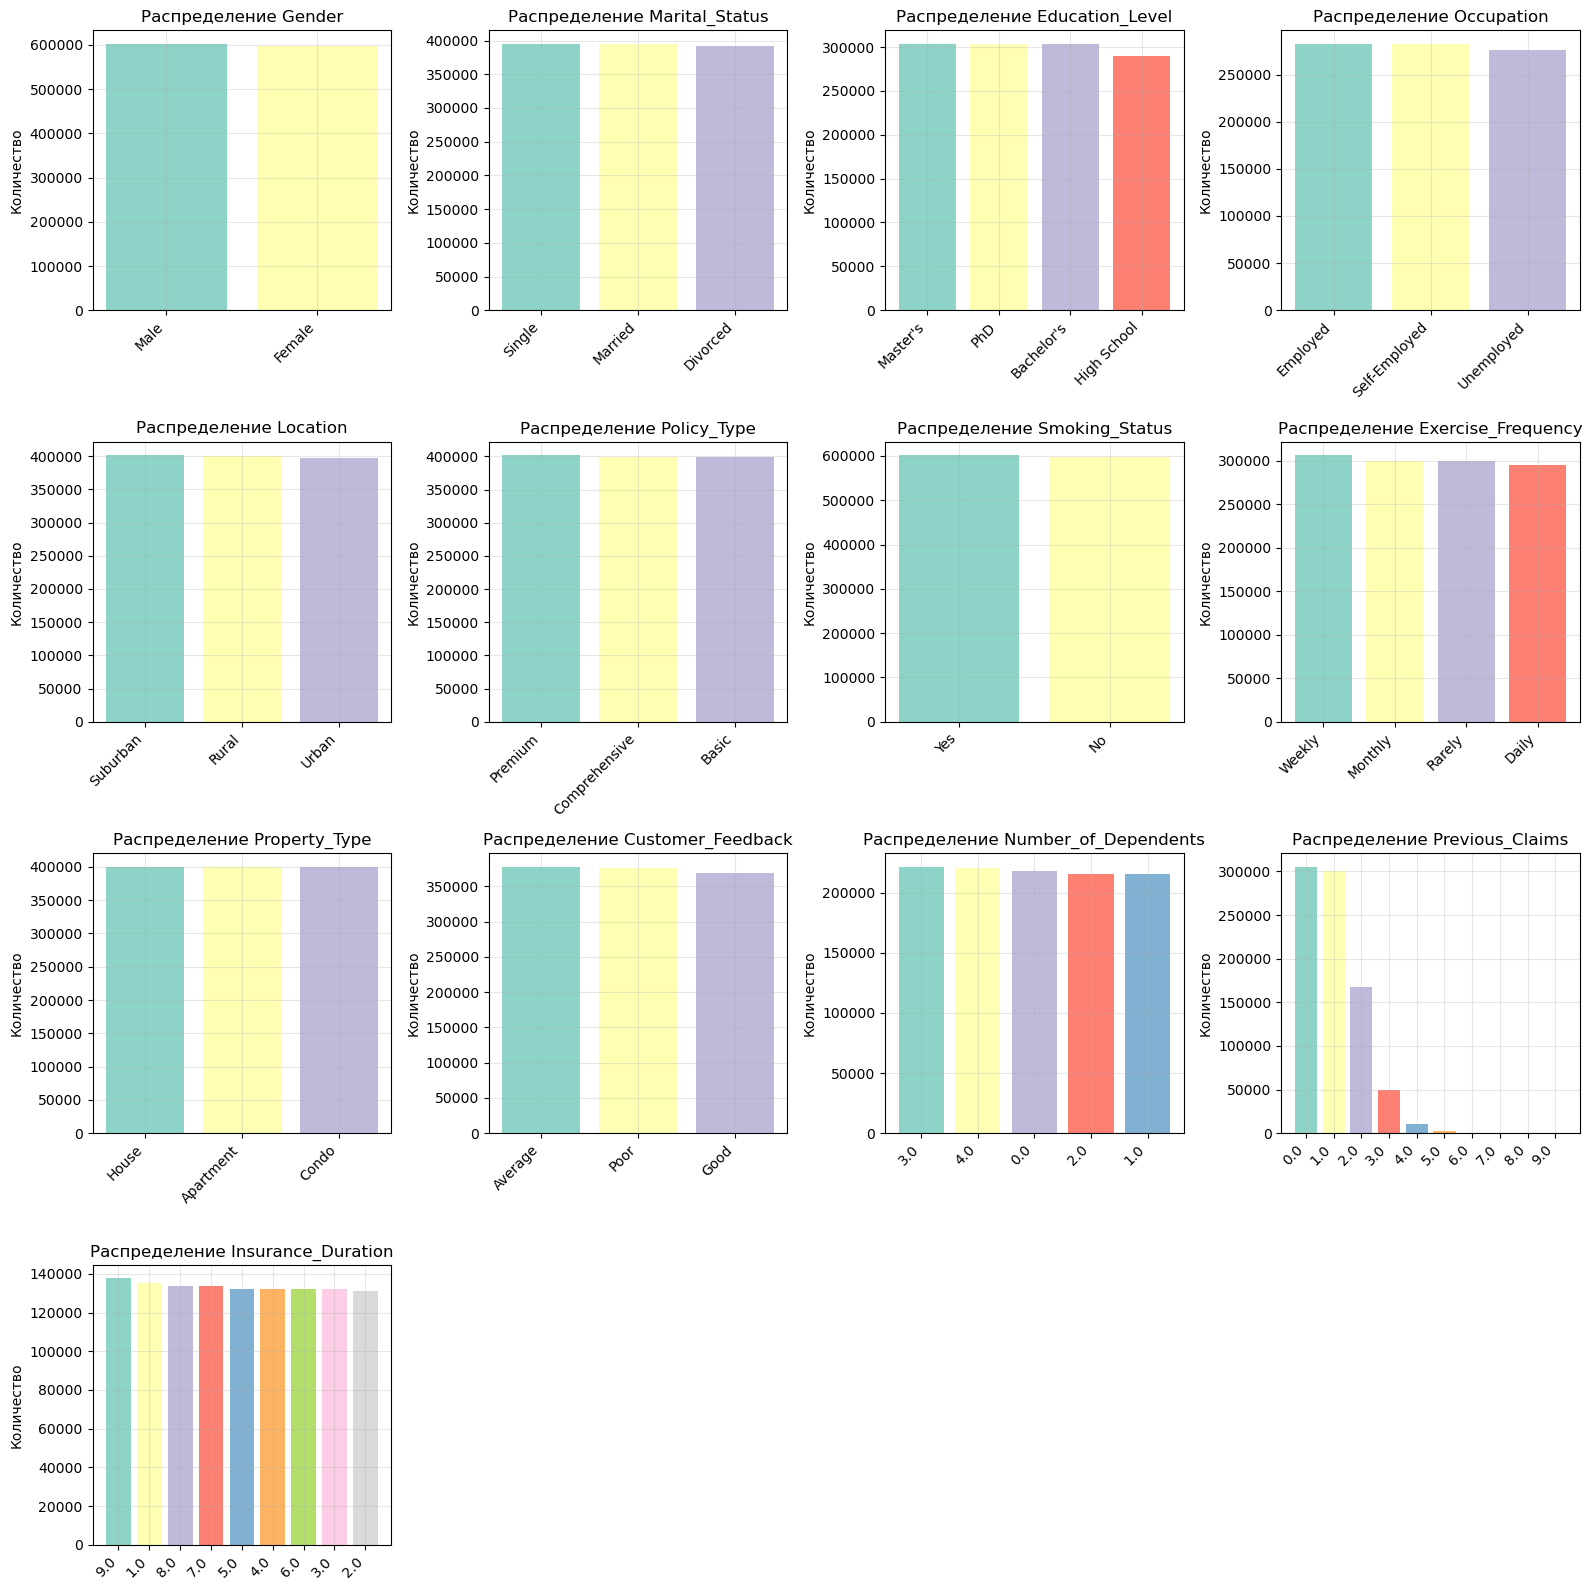

In [ ]:
n = len(categorical_cols)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    
    axes[i].bar(
        range(len(value_counts)),
        value_counts.values,
        color=sns.color_palette("Set3")
    )
    
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_ylabel('Количество')
    axes[i].grid(True, alpha=0.3)

for j in range(n, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Видно, что распределение Previous_Claims неравномерное - большинство людей не подавали много страховых заявок. Остальные распределения либо почти, либо полностью равномерные. Скорее всего дело в синтетической природе в данных, в реальности картина должна быть другой

Также построим боксплоты, которые покажут взаимосвязь категориальных признаков с таргетом:

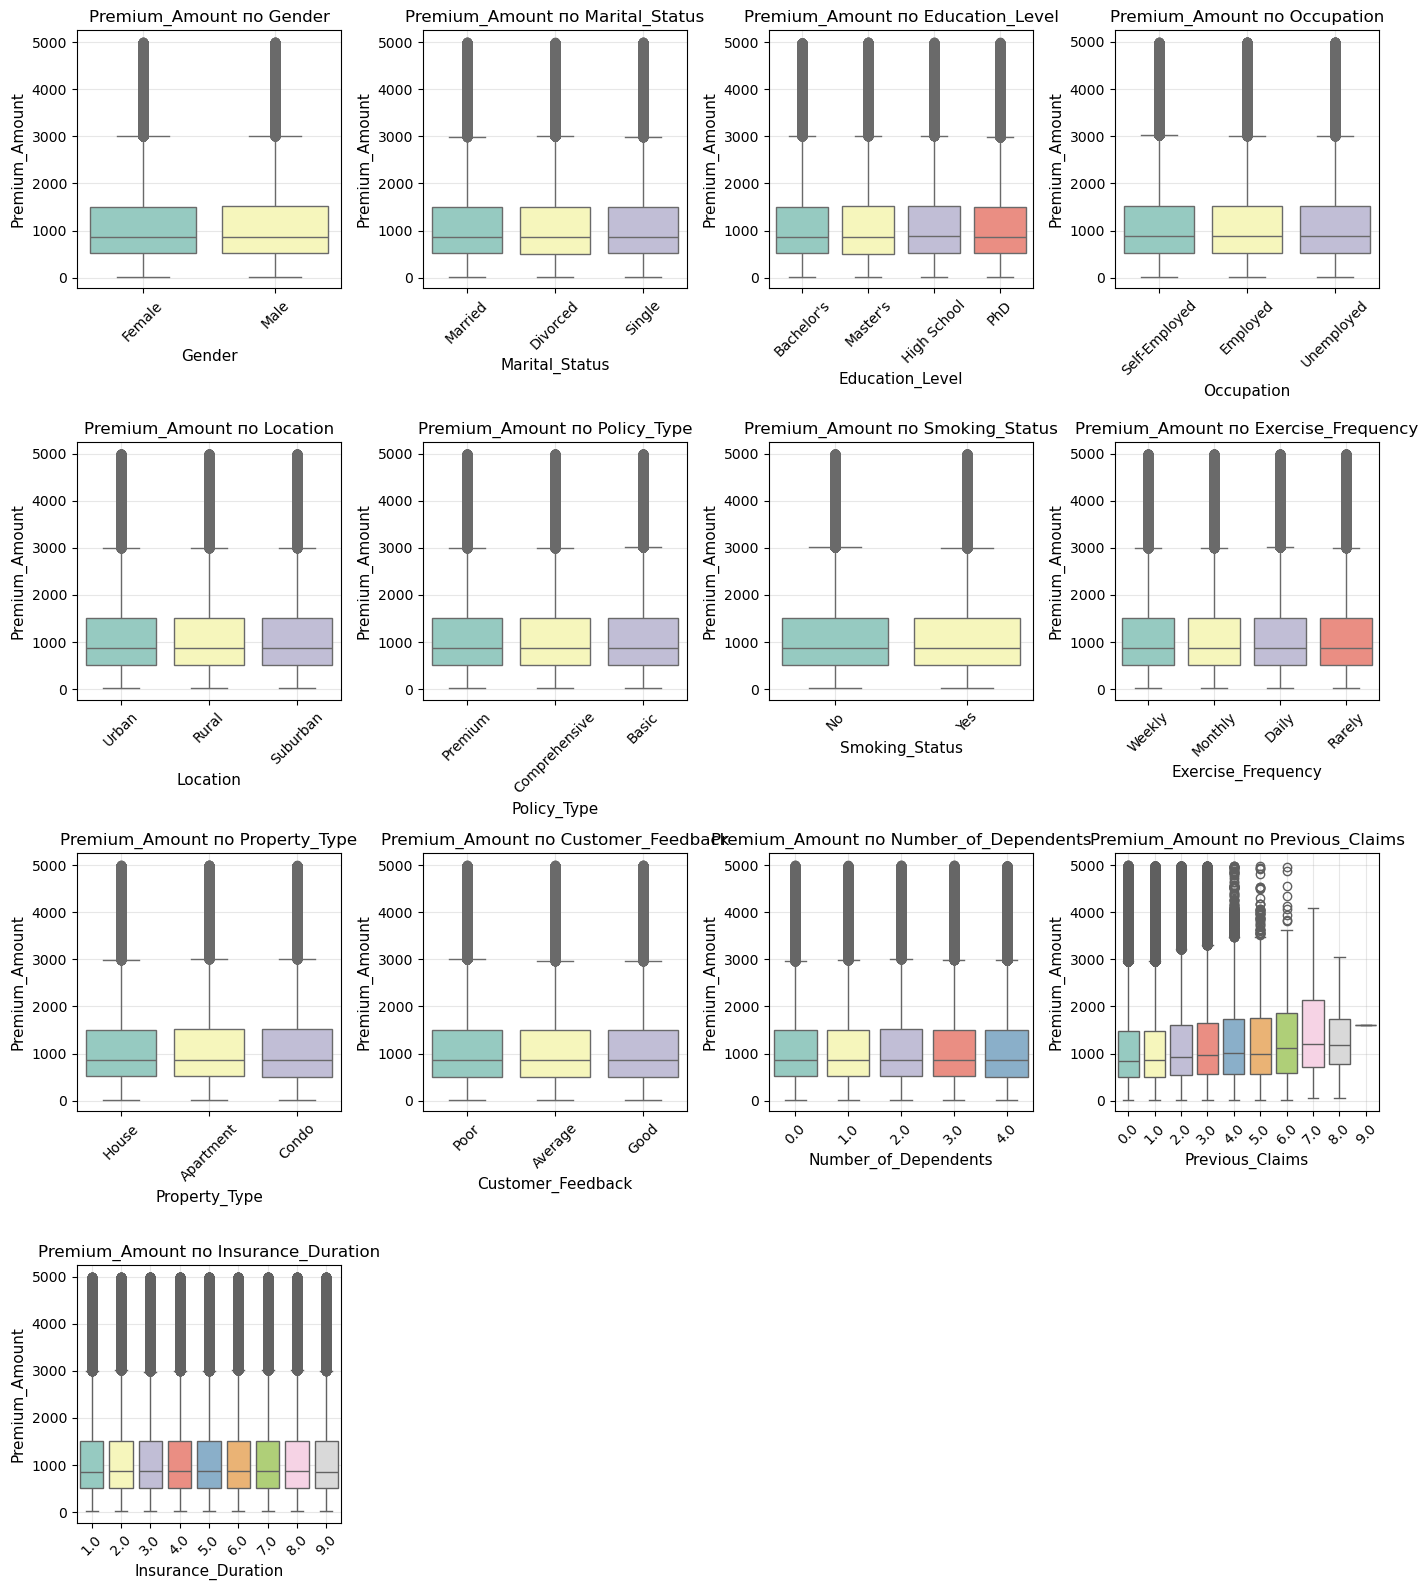

In [ ]:
target_col = 'Premium_Amount'

n = len(categorical_cols)
ncols = 4
nrows = (n + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows * 4))
axes = axes.flatten()

palette = sns.color_palette("Set3")

for i, col in enumerate(categorical_cols):
    sns.boxplot(
        data=df,
        x=col,
        y=target_col,
        ax=axes[i],
        palette=palette
    )
    
    axes[i].set_title(f'{target_col} по {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel(target_col, fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

for j in range(len(categorical_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Единственная зависимость наблюдается для признака "Previous_Claimns" - люди которые часто обращались в страховую компанию, имеют большуюю сумму страховой премии. 

Для остальных категорий отсутствуют явно выражение различия, следовательно, линейных зависимостей премии от этих  признаков.

Теперь визуализируем признаки с датой:

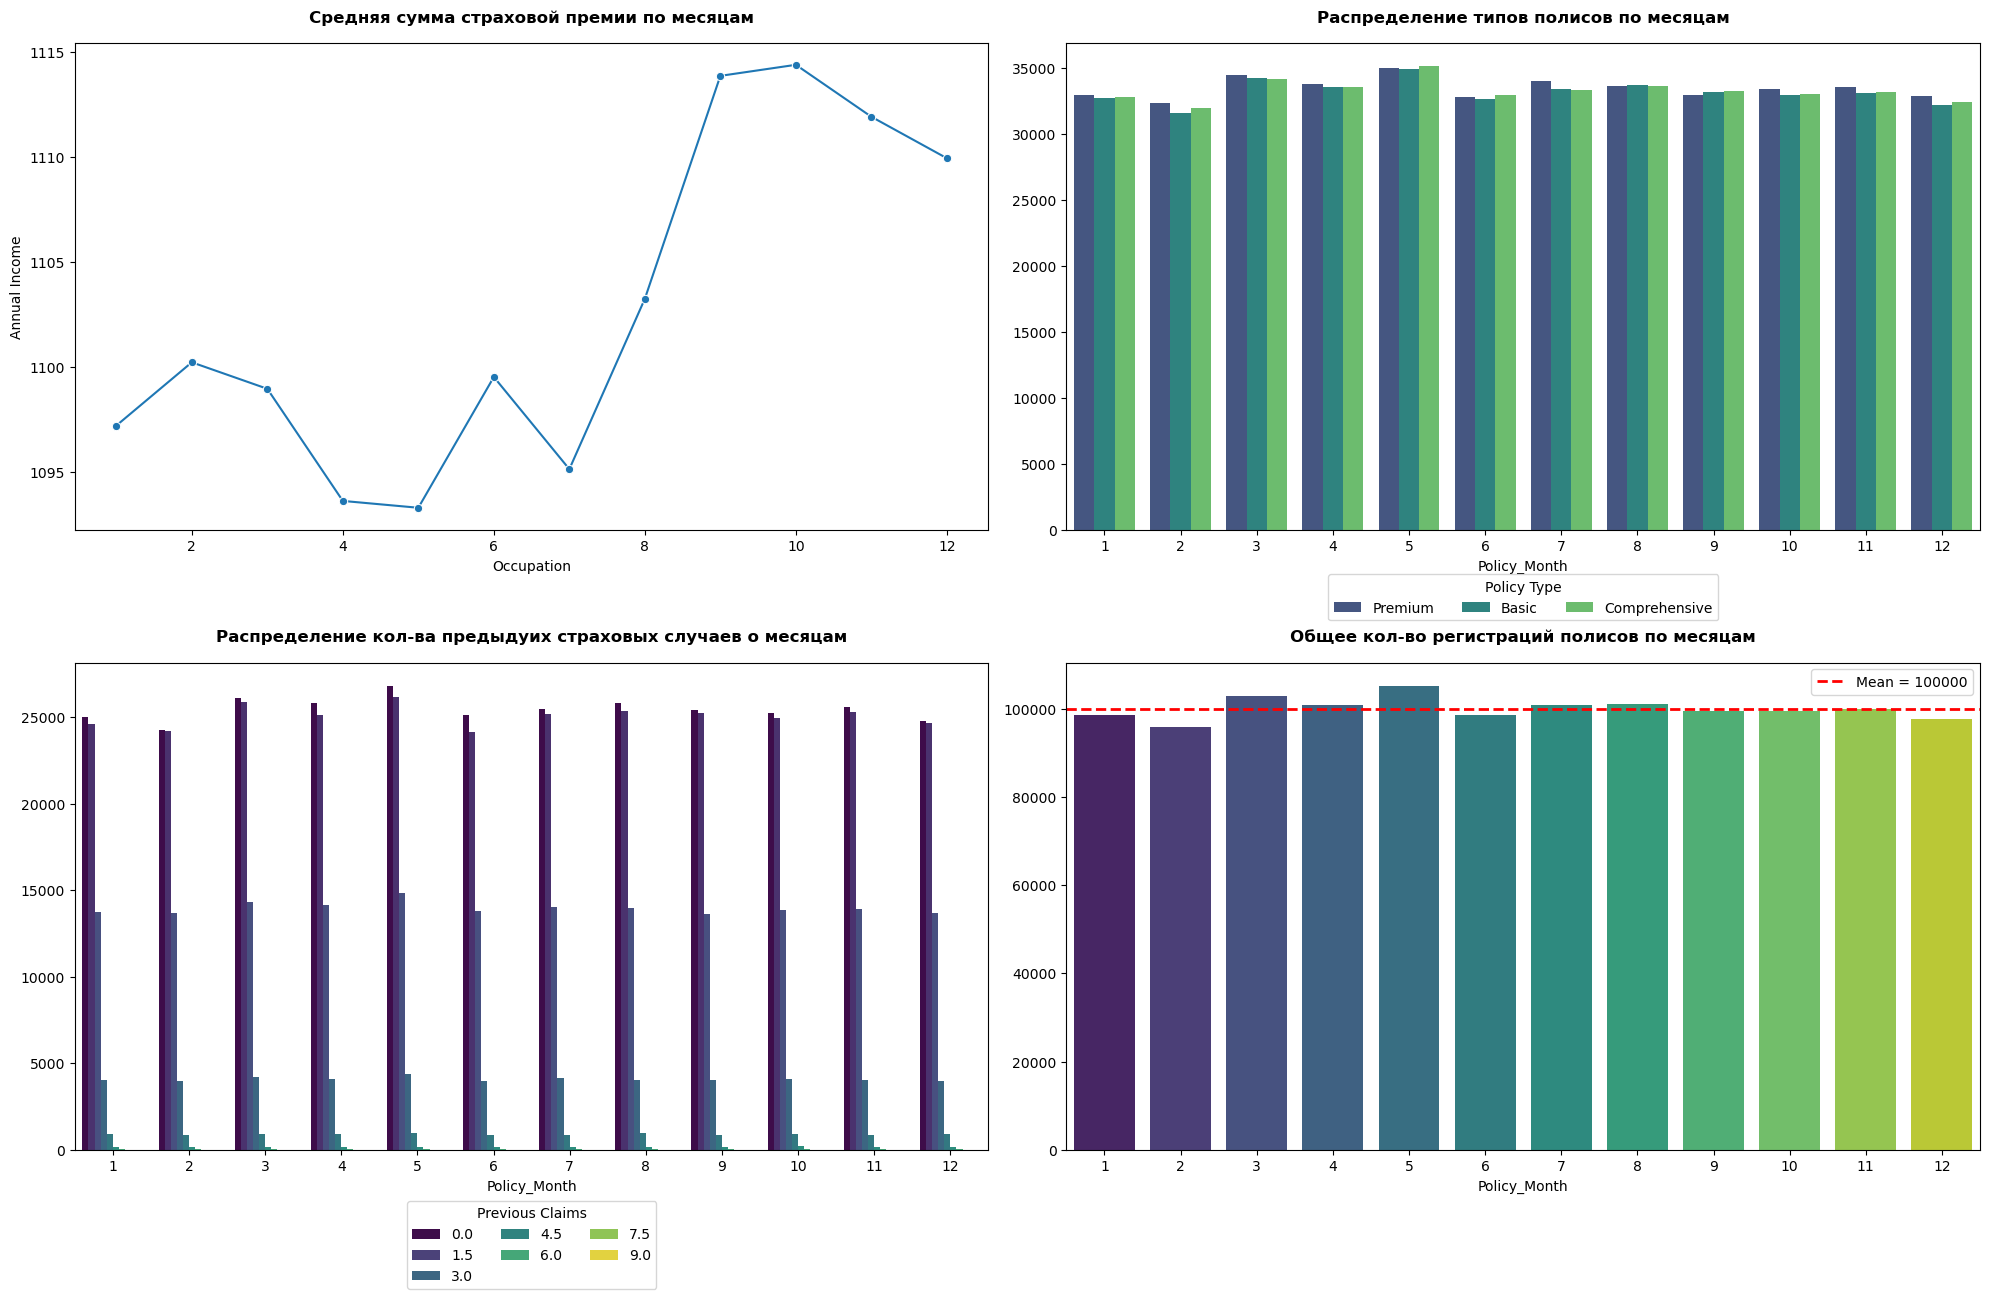

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(20, 13))
avg_premium_by_month = df.groupby("Policy_Month")["Premium_Amount"].mean().reset_index()
sns.lineplot(
    data=avg_premium_by_month,
    y="Premium_Amount",
    x="Policy_Month",
    ax=ax[0, 0],
    marker="o"
)
ax[0, 0].set_xlabel("Occupation")
ax[0, 0].set_ylabel("Annual Income")
ax[0, 0].set_title("Средняя сумма страховой премии по месяцам", pad=15, weight = "bold")

sns.countplot(
    data=df,
    x="Policy_Month",
    hue="Policy_Type",
    ax=ax[0, 1],
    palette="viridis"
)
ax[0, 1].set_xlabel("Policy_Month")
ax[0, 1].set_ylabel("")
ax[0, 1].set_title("Распределение типов полисов по месяцам", pad=15, weight = "bold")
ax[0, 1].legend(title="Policy Type", loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3)

sns.countplot(
    data=df,
    x="Policy_Month",
    hue="Previous_Claims",
    ax=ax[1, 0],
    palette="viridis"
)
ax[1, 0].set_xlabel("Policy_Month")
ax[1, 0].set_ylabel("")
ax[1, 0].set_title("Распределение кол-ва предыдуих страховых случаев о месяцам", pad=15, weight = "bold")
ax[1, 0].legend(title="Previous Claims", loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

sns.countplot(
    data=df,
    x="Policy_Month",
    ax=ax[1, 1],
    palette="viridis"
)

monthly_counts = df["Policy_Month"].value_counts().sort_index()
mean_count = monthly_counts.mean()

ax[1, 1].axhline(mean_count, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_count:.0f}")
ax[1, 1].legend(loc="upper right")

ax[1, 1].set_xlabel("Policy_Month")
ax[1, 1].set_ylabel("")
ax[1, 1].set_title("Общее кол-во регистраций полисов по месяцам", pad=15, weight="bold")

plt.tight_layout()
plt.show()

Распределения типов полисов, кол-ва предыдущих страховых случаев и общее кол-во регистраций по полисам стабильно в течении года. Однако наблюдается, сезон пиковых регистраций новых полисов с март по май, но это кол-во незначительно (1100 против 1115)

## Препроцессинг

In [28]:
summary = []

for col in df.columns:
    if col in numerical_cols:
        col_type = "Числовой"
    elif col in categorical_cols:
        col_type = "Категориальный"
    else:
        col_type = "Другой тип"
    
    summary.append({
        "Столбец": col,
        "Тип": col_type,
        "Уникальные значения": df[col].nunique(),
    })

summary_df = pd.DataFrame(summary)
summary_df

,Столбец,Тип,Уникальные значения
0,Age,Числовой,47
1,Gender,Категориальный,2
2,Annual_Income,Числовой,88593
3,Marital_Status,Категориальный,3
4,Number_of_Dependents,Категориальный,5
5,Education_Level,Категориальный,4
6,Occupation,Категориальный,3
7,Health_Score,Числовой,532657
8,Location,Категориальный,3
9,Policy_Type,Категориальный,3


Первым делом выберем признаки и составим матрицу признаков и целевую переменную. 

Затем разобьем данные на обучающую и тестовую выборки в соотношении 80/20.

### Стратегия кодирования категориальных признаков:

На основе анализа категориальных признаков из EDA применяем разные стратегии:

1. Для бинарных и порядковых признаков (Gender, Smoking Status,Exercise Frequency) → **Ordinal Encoding**

2. Для номальных признаков (Marital Status, Education Level, Occupation,
    Location, Policy Type, Customer Feedback, Property Type) → **One-Hot Encoding**

После кодирования категориальных признаков создаем пайплайны: 

- численные признаки  масштабируются с помощью StandardScaler
- импутация пропусков: замена медианным значением для численных и отдельная категория "Unknown" для категориальных признаков с пропусками

Также логарифмируем целевую переменную, т.к. визуальный анализ целевой переменной показал что ее распределение сильно ассиметричное. После логарифмирования распределение становится почти нормальным, что улучшает обучаемость моделей

In [29]:
categorical_cols

['Gender',
 'Marital_Status',
 'Education_Level',
 'Occupation',
 'Location',
 'Policy_Type',
 'Smoking_Status',
 'Exercise_Frequency',
 'Property_Type',
 'Customer_Feedback',
 'Number_of_Dependents',
 'Previous_Claims',
 'Insurance_Duration']

In [30]:
X = df.drop(['Premium_Amount','Policy_Start_Date'], axis=1, errors='ignore')
y = np.log1p(df['Premium_Amount'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Размеры наборов:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Размеры наборов:
X_train: (960000, 21), y_train: (960000,)
X_test: (240000, 21), y_test: (240000,)


In [31]:
numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

In [32]:
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    
    ('bin_ord', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), binary_features + ordinal_features),
    
    ('nom', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]), nominal_features)
], remainder='drop')

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("\n" + "="*60)
print("Результаты после препроцессинга:")
print("="*60)
print(f"X_train_proc: {X_train_proc.shape}")
print(f"X_test_proc:  {X_test_proc.shape}")


Результаты после препроцессинга:
X_train_proc: (960000, 39)
X_test_proc:  (240000, 39)


## Обучение моделей (бейзлайн)

Так как в прошедшем соревновании кэггла, в котором использовался этот датасет, основной метрикой была RMSLE будем опираться на нее, а остальные приводить лишь в качестве вспомогательных

В качестве первой модели возьмем DecisionTree

{'model': 'Decision Tree Regressor', 'mse': 849766.301189081, 'rmse': np.float64(921.8276960414463), 'mae': 622.8141455968585, 'r2': -0.13713728321217622, 'rmsle': np.float64(1.0507390599892081)}


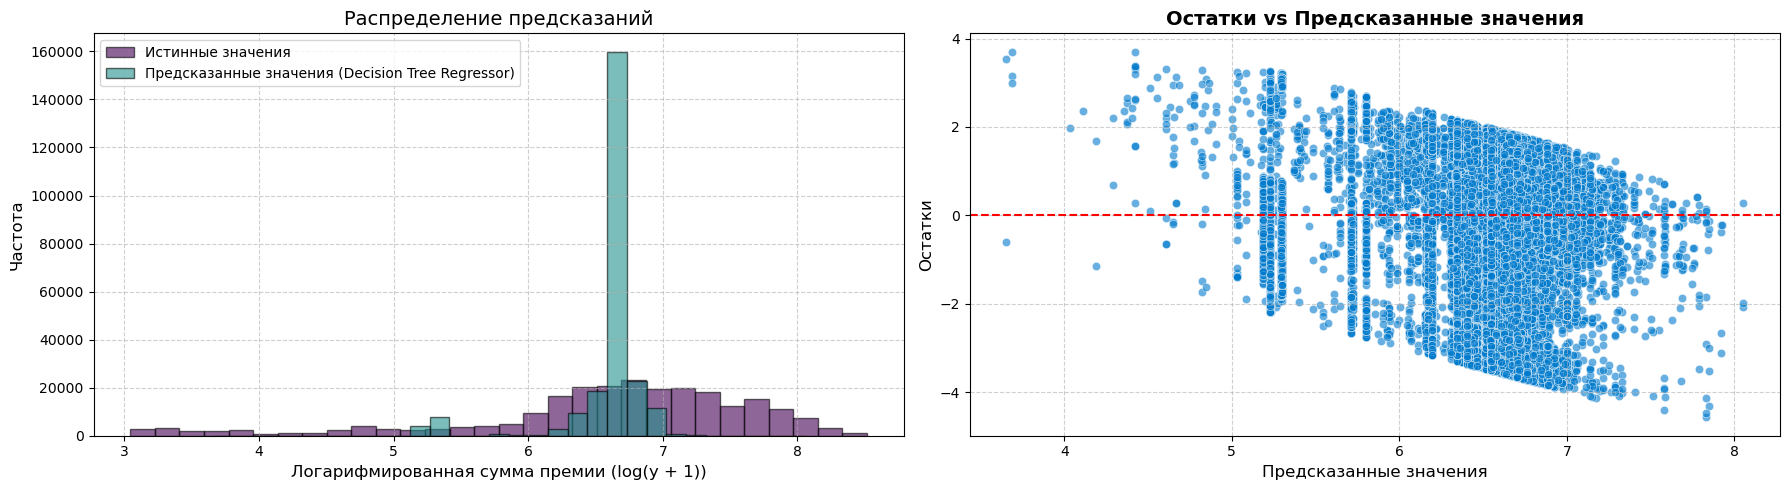

In [ ]:
metrics_list = []

tree_model = DecisionTreeRegressor(
    max_depth=10,    
    min_samples_leaf=5,  
    random_state=42
)

tree_model.fit(X_train_proc, y_train)
log_pred_tree = tree_model.predict(X_test_proc)

metrics_list.append(
    evaluate_and_report(
        y_true_log=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred_log=log_pred_tree,
        model_name='Decision Tree Regressor',
    )
)

plot_prediction_distr(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=log_pred_tree,
    model_name='Decision Tree Regressor',
)


Далее обучим ансамбль деревьев решений:

{'model': 'Random Forest', 'mse': 862373.0876211964, 'rmse': np.float64(928.640451208753), 'mae': 626.5411957929497, 'r2': -0.154007388385083, 'rmsle': np.float64(1.0615979875516908)}


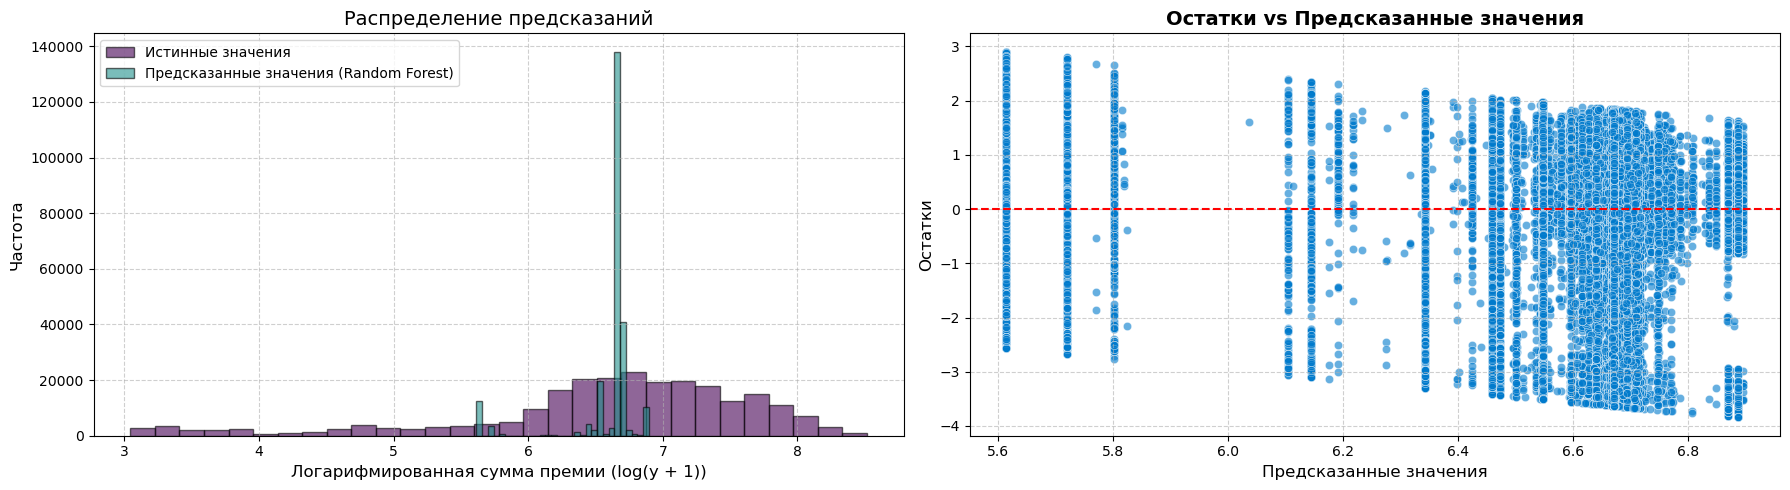

In [ ]:
rf_model = RandomForestRegressor(max_depth = 5, n_estimators=10, random_state=42
)

rf_model.fit(X_train_proc, y_train)
log_pred_rf = rf_model.predict(X_test_proc)

metrics_list.append(
    evaluate_and_report(
        y_true_log=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred_log=log_pred_rf,
        model_name='Random Forest',
    )
)
plot_prediction_distr(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=log_pred_rf,
    model_name='Random Forest',
)

По метрике RMSLE случайный лес получился лучше чем ансамбль деревьев

Посморим на важность признаков этих двух моделей:

Количество признаков после препроцессинга: 39
Первые 10 признаков: ['num__Age', 'num__Annual_Income', 'num__Number_of_Dependents', 'num__Health_Score', 'num__Previous_Claims', 'num__Vehicle_Age', 'num__Credit_Score', 'num__Insurance_Duration', 'num__Policy_Year', 'num__Policy_Month']


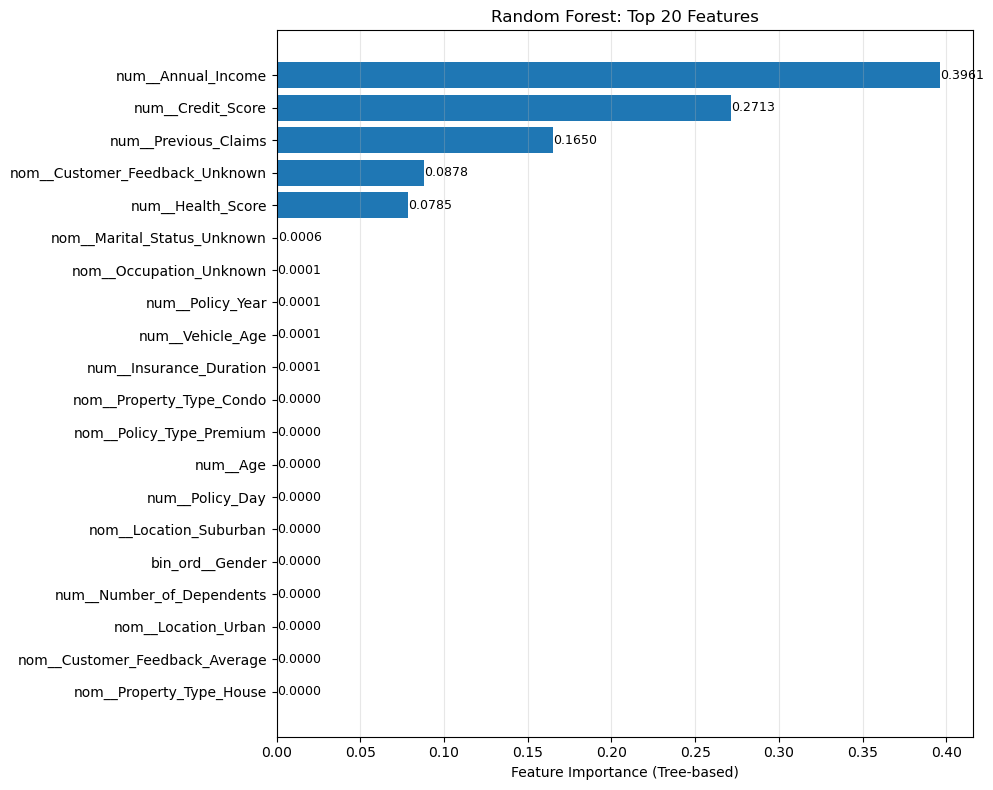

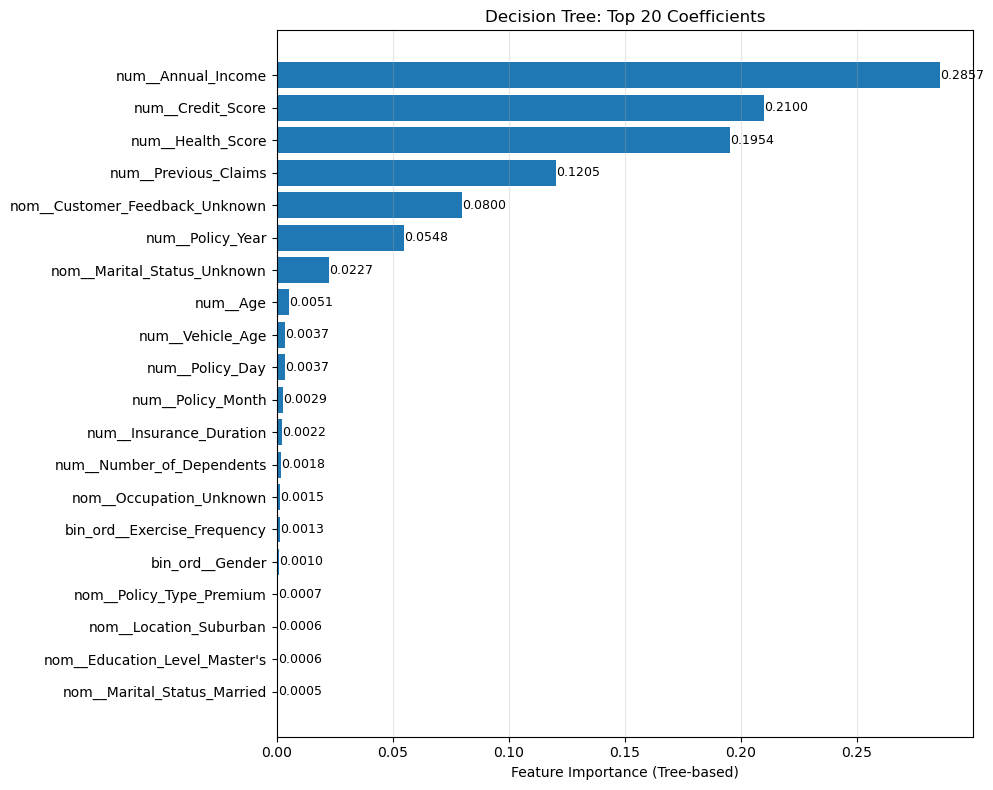

In [ ]:
feature_names = preprocessor.get_feature_names_out()

print(f"Количество признаков после препроцессинга: {len(feature_names)}")
print(f"Первые 10 признаков: {feature_names[:10].tolist()}")

plot_feature_importance(
    rf_model,
    feature_names=feature_names,
    top_n=20,
    title='Random Forest: Top 20 Features'
)

plot_feature_importance(
    tree_model,
    feature_names=feature_names,
    top_n=20,
    title='Decision Tree: Top 20 Coefficients'
)


Обе модели, наиболее важными признаками выделяют Годовой доход, кредитный рейтинг, показатель здоровья и кол-во предыдущих страховых случаев. Random Forest имеет более концентрированное распределение важности на топ-3 признака, а Decision Tree показывает более равномерное распределение среди большего их числа

Далее обучим модели бустинга XGBoost и LightGBM

{'model': 'XGBoost', 'mse': 859747.3439568513, 'rmse': np.float64(927.2256165339973), 'mae': 625.43499733874, 'r2': -0.15049367995406282, 'rmsle': np.float64(1.0533180971674656)}


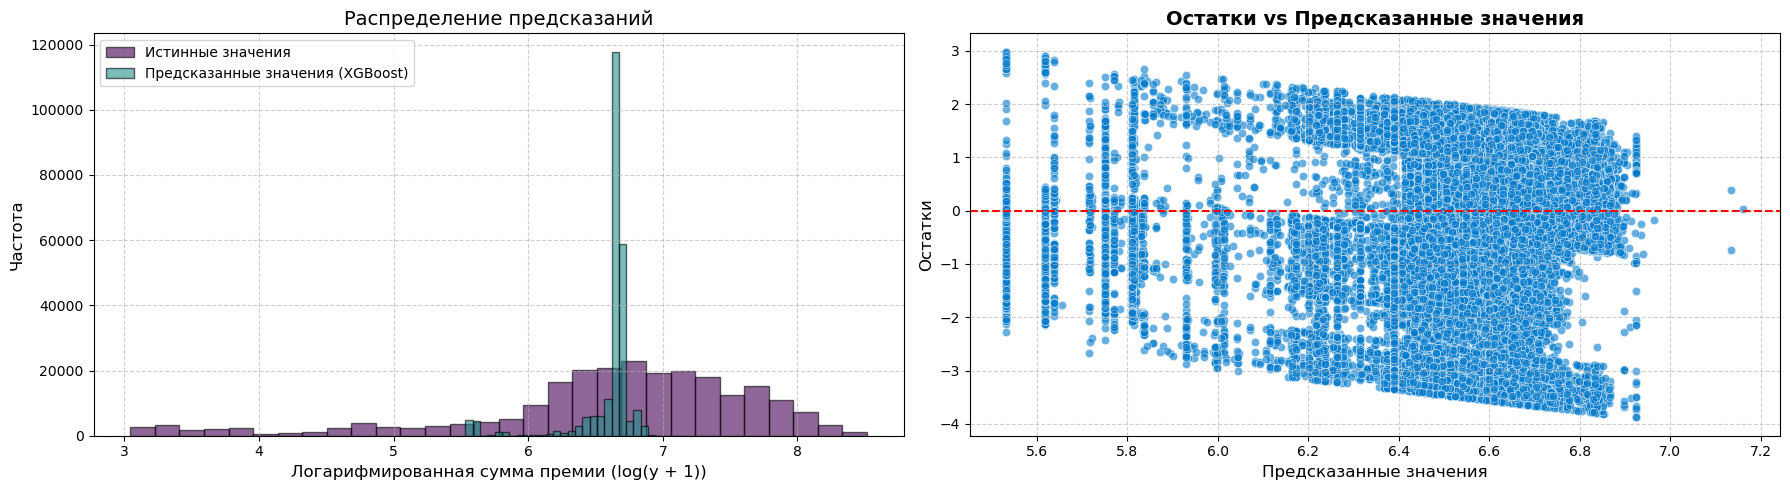

In [ ]:
xgb = XGBRegressor(
    n_estimators=20, 
    max_depth=6, 
    learning_rate=0.1,
    random_state=42
)


xgb.fit(X_train_proc, y_train)

log_pred_xgb = xgb.predict(X_test_proc)

metrics_list.append(
    evaluate_and_report(
        y_true_log=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred_log=log_pred_xgb,
        model_name='XGBoost',
    )
)

plot_prediction_distr(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=log_pred_xgb,
    model_name='XGBoost',
)


Тут уже получаем достаточно высокий Precision, но чуть худший Recall. Модель все еще часто ошибается и не охватывает достаточное кол-во мошеннеческих транзакций

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 39
[LightGBM] [Info] Start training from score 6.593848
{'model': 'LightGBM', 'mse': 858888.7026261128, 'rmse': np.float64(926.7624844727546), 'mae': 625.230346272713, 'r2': -0.14934466631499133, 'rmsle': np.float64(1.052775171663473)}


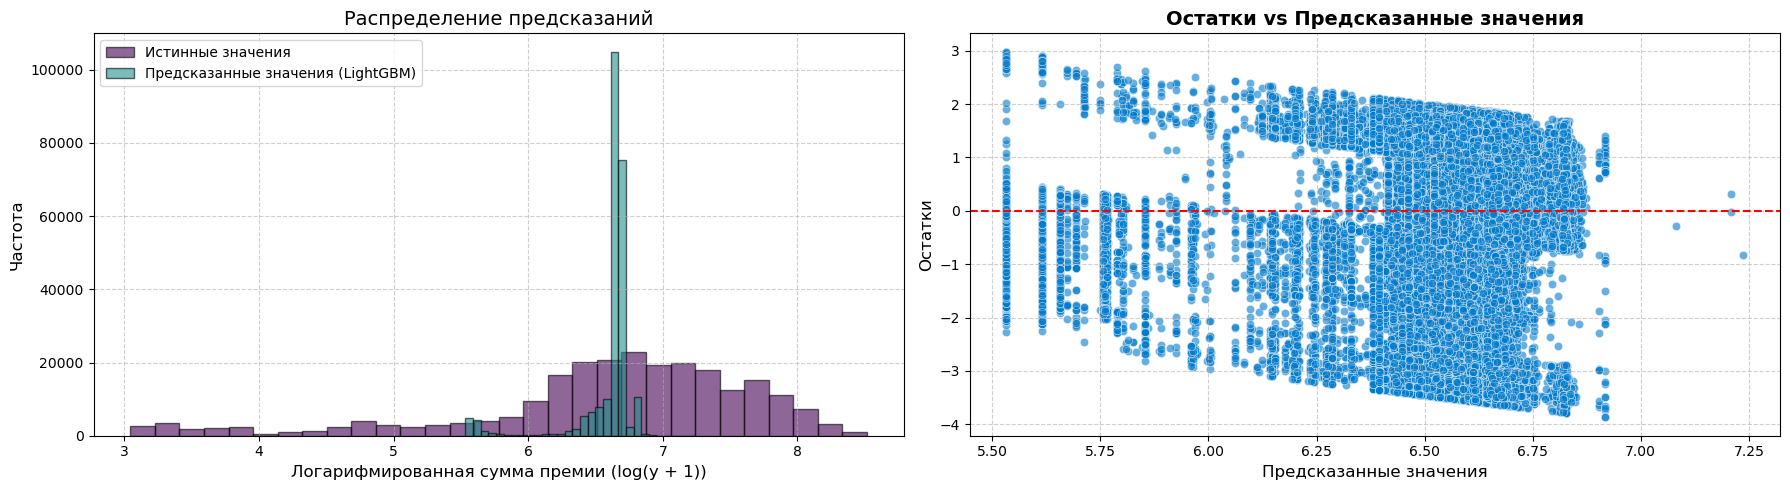

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=20,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

lgbm.fit(X_train_proc, y_train)

log_pred_lgbm = lgbm.predict(X_test_proc)

metrics_list.append(
    evaluate_and_report(
        y_true_log=y_test.values if hasattr(y_test, 'values') else y_test,
        y_pred_log=log_pred_lgbm,
        model_name='LightGBM',
    )
)

plot_prediction_distr(
    y_true=y_test.values if hasattr(y_test, 'values') else y_test,
    y_pred=log_pred_lgbm,
    model_name='LightGBM',
)


Бустинг модели показали примерно равные результаты, нужно смотреть что происходит дальше на feature engineering

Анализ важности признаков для XGBoost:


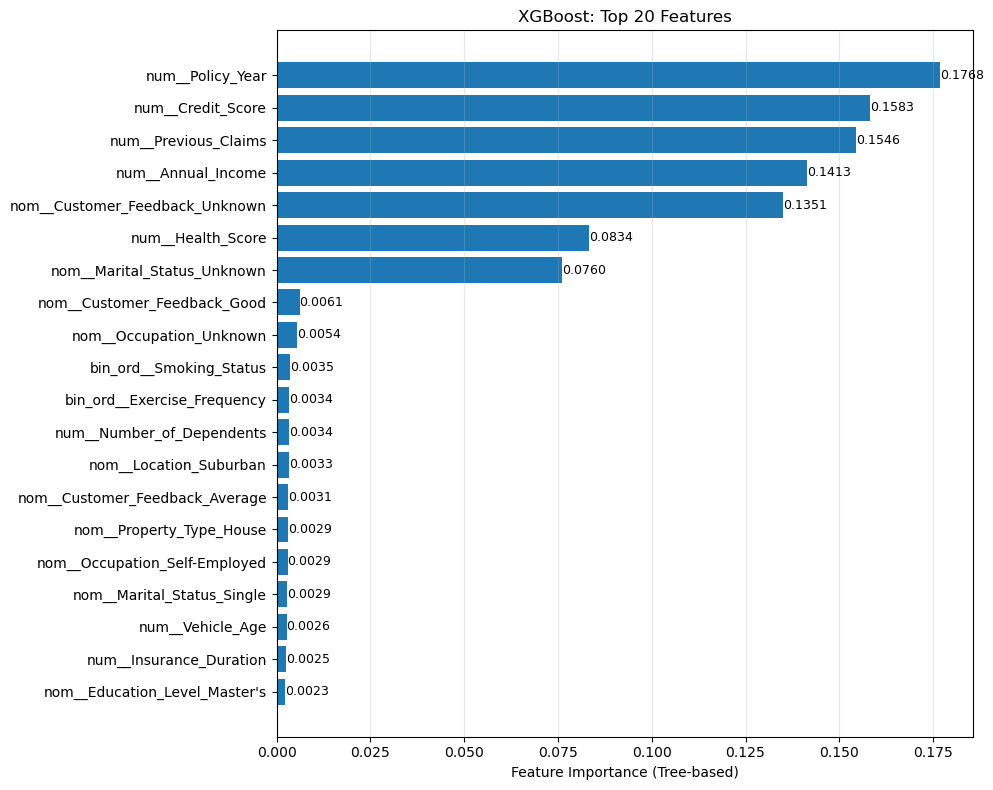

Анализ важности признаков для LightGBM:


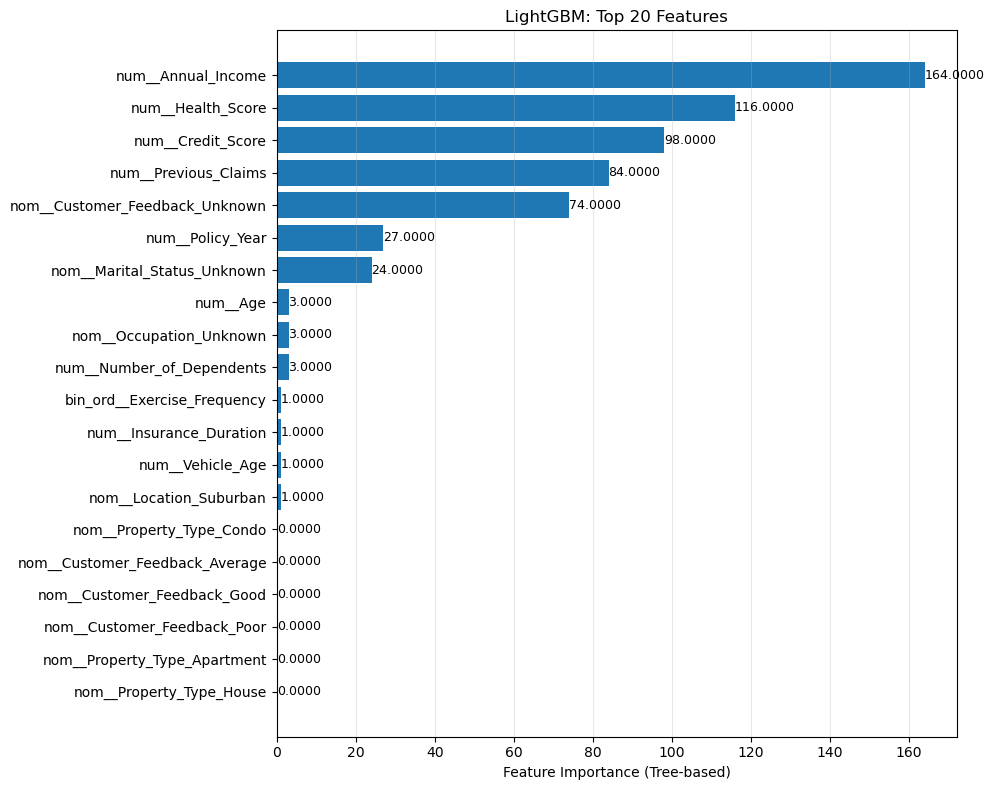

In [43]:
if 'xgb' in globals() and hasattr(xgb, 'feature_importances_'):
    print("Анализ важности признаков для XGBoost:")
    plot_feature_importance(
        xgb,
        feature_names=feature_names,
        top_n=20,
        title='XGBoost: Top 20 Features'
    )

if 'lgbm' in globals() and hasattr(lgbm, 'feature_importances_'):
    print("Анализ важности признаков для LightGBM:")
    plot_feature_importance(
        lgbm,
        feature_names=feature_names,
        top_n=20,
        title='LightGBM: Top 20 Features'
    )


XGBoost предполагает сильную связь между доходом и таргетом, а для LightGBM наиболее важный признак - год заключения сделки. Остальные признаки по важности примерно схожи - кредитный рейтинг и рейтинг здоровья и кол-во предыдущих обращений

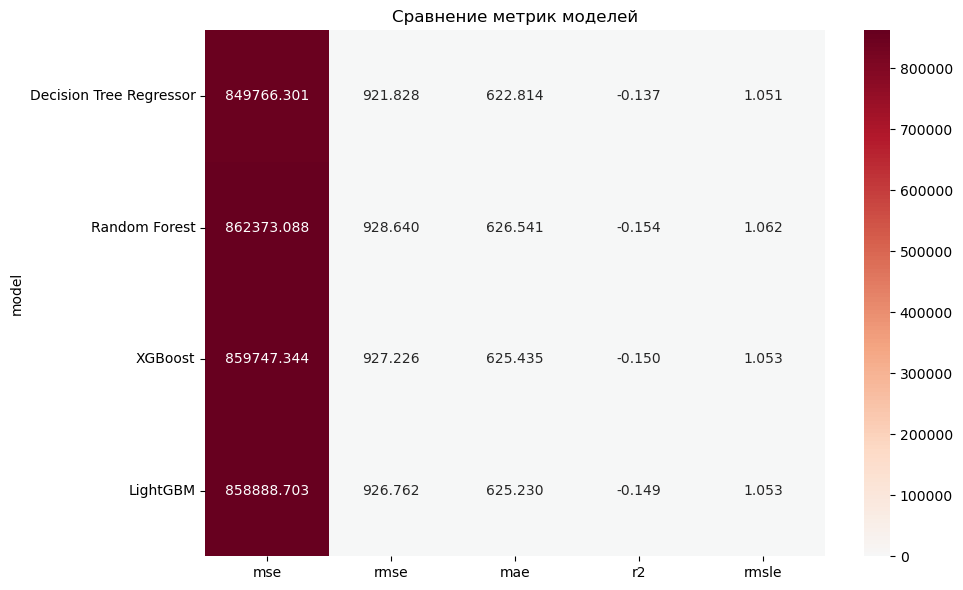

In [ ]:
metrics_df = compare_models_metrics(metrics_list)